In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

In [2]:
root_dir = os.path.join(os.getcwd(), '..')
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(root_dir)
sys.path.append(src_dir)

from d00_utils.binning import BinTime

In [3]:
current_log = pd.read_csv(os.path.join(root_dir, 'data', 'current_log.csv'), index_col=0)

In [4]:
# convert unix times to datetimes
times_lst = ['reception_time', 'reference_time', 'sunrise_time', 'sunset_time']

tz_correct = 60 * 60 * 4

for col_n in ['reception_time', 'reference_time']:
    current_log[col_n] = pd.to_datetime(current_log[col_n], unit='s')

for col_n in ['sunrise_time', 'sunset_time']:
    current_log[col_n] = pd.to_datetime(current_log[col_n] - tz_correct, unit='s')


In [5]:
current_log['time_bin'] = BinTime(current_log['reception_time'])

binned_current_log = pd.concat(
    [current_log.groupby(['time_bin']).mean(),
     current_log.groupby(['time_bin']).max()[['park_name', 'sunrise_time', 'sunset_time', 'status', 'detailed_status']]],
    axis=1, sort=False)

In [6]:
binned_current_log.head(5)

,clouds,rain_1h,snow_1h,wind_speed,wind_deg,humidity,press,temp,temp_feels,temp_max,temp_min,park_name,sunrise_time,sunset_time,status,detailed_status
time_bin,,,,,,,,,,,,,,,,
2020-04-04 08:35:00,90.0,0.25,0.0,5.10,40.0,93.0,1016.0,46.40,38.70,48.200,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain
2020-04-04 08:50:00,90.0,0.25,0.0,4.60,40.0,93.0,1016.0,46.60,39.56,48.200,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain
2020-04-04 09:05:00,90.0,0.00,0.0,4.60,40.0,93.0,1016.0,46.69,39.67,48.200,44.6,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain
2020-04-04 09:20:00,90.0,0.00,0.0,4.35,45.0,93.0,1016.0,46.95,40.31,48.595,45.0,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain
2020-04-04 09:35:00,90.0,0.00,0.0,4.10,50.0,93.0,1016.0,47.05,40.75,48.990,45.0,Prospect Park,2020-04-04 06:33:33,2020-04-04 19:23:28,Rain,light rain


(737518.3576388889, 737530.3472222222)

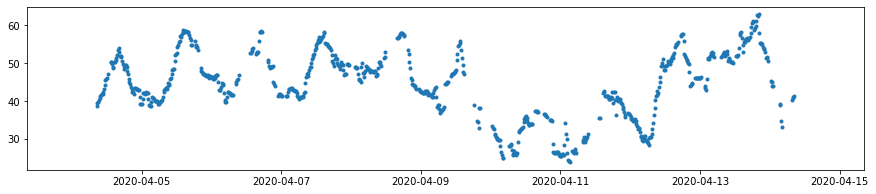

In [7]:
plt.figure(figsize=(15,3))

plt.scatter(binned_current_log.index, binned_current_log.temp_feels, marker='.')
plt.xlim((min(binned_current_log.index)-timedelta(days=1), max(binned_current_log.index)+timedelta(days=1)))

In [8]:
# create df with all possible time bins
start = min(binned_current_log.index)
end = max(binned_current_log.index)

num_bins = int(1 + (end - start) / timedelta(minutes=15))
t = np.linspace(start.value, end.value, num_bins)

all_bins = pd.DataFrame({'time_bin': pd.to_datetime(t)})

In [9]:
# join data to all bins
all_bins_df = all_bins.set_index('time_bin').join(binned_current_log)

In [10]:
# interpolate some missing data
interp_2nd = ['press', 'temp', 'temp_feels', 'temp_max', 'temp_min']

interp_1st = ['clouds', 'humidity']

interp_min = ['wind_speed', 'wind_deg']

for col in interp_1st:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=1, limit_direction ='forward')

for col in interp_2nd:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=2, limit_direction ='forward')

for col in interp_min:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=1, limit_direction ='forward').clip(lower=0)

In [11]:
all_bins_df.columns

Index(['clouds', 'rain_1h', 'snow_1h', 'wind_speed', 'wind_deg', 'humidity',
       'press', 'temp', 'temp_feels', 'temp_max', 'temp_min', 'park_name',
       'sunrise_time', 'sunset_time', 'status', 'detailed_status'],
      dtype='object')

(737518.3576388889, 737530.3472222222)

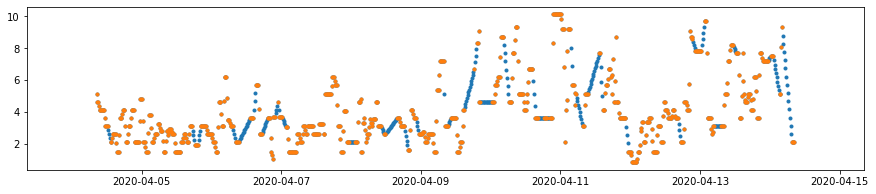

In [12]:
plot_col = 'wind_speed'

plt.figure(figsize=(15,3))

plt.scatter(all_bins_df.index, all_bins_df[plot_col], marker='.')
plt.scatter(binned_current_log.index, binned_current_log[plot_col], marker='.')
plt.xlim((min(all_bins_df.index)-timedelta(days=1), max(all_bins_df.index)+timedelta(days=1)))

In [13]:
binned_current_log[['sunrise_time', 'sunset_time', 'clouds', 'rain_1h', 'snow_1h', 'wind_speed',
                    'humidity', 'press', 'temp_feels']]

,sunrise_time,sunset_time,clouds,rain_1h,snow_1h,wind_speed,humidity,press,temp_feels
time_bin,,,,,,,,,
2020-04-04 08:35:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.25,0.0,5.10,93.0,1016.0,38.700000
2020-04-04 08:50:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.25,0.0,4.60,93.0,1016.0,39.560000
2020-04-04 09:05:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.60,93.0,1016.0,39.670000
2020-04-04 09:20:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.35,93.0,1016.0,40.310000
2020-04-04 09:35:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.10,93.0,1016.0,40.750000
...,...,...,...,...,...,...,...,...,...
2020-04-14 04:05:00,2020-04-14 06:17:43,2020-04-14 19:33:52,40.0,0.00,0.0,9.30,53.0,1015.0,33.150000
2020-04-14 07:35:00,2020-04-14 06:17:43,2020-04-14 19:33:52,1.0,0.00,0.0,2.10,58.0,1017.0,40.390000
2020-04-14 07:50:00,2020-04-14 06:17:43,2020-04-14 19:33:52,1.0,0.00,0.0,2.10,58.0,1017.0,40.846667


In [14]:
(binned_current_log['sunset_time'] - binned_current_log['sunrise_time']) / 2

time_bin
2020-04-04 08:35:00   06:24:57.500000
2020-04-04 08:50:00   06:24:57.500000
2020-04-04 09:05:00   06:24:57.500000
2020-04-04 09:20:00   06:24:57.500000
2020-04-04 09:35:00   06:24:57.500000
                            ...      
2020-04-14 04:05:00   06:38:04.500000
2020-04-14 07:35:00   06:38:04.500000
2020-04-14 07:50:00   06:38:04.500000
2020-04-14 08:05:00   06:38:04.500000
2020-04-14 08:20:00   06:38:04.500000
Length: 750, dtype: timedelta64[ns]

In [15]:
binned_current_log['peak_time'] = binned_current_log['sunrise_time'] + (binned_current_log['sunset_time'] - binned_current_log['sunrise_time']) / 2

In [16]:
binned_current_log['peak_time'] = abs(binned_current_log['peak_time'] - binned_current_log.index)


In [17]:
binned_current_log['peak_time'][50:100]

time_bin
2020-04-04 21:50:00   08:51:29.500000
2020-04-04 22:05:00   09:06:29.500000
2020-04-04 22:20:00   09:21:29.500000
2020-04-04 22:35:00   09:36:29.500000
2020-04-04 22:50:00   09:51:29.500000
2020-04-04 23:05:00   10:06:29.500000
2020-04-04 23:20:00   10:21:29.500000
2020-04-04 23:35:00   10:36:29.500000
2020-04-04 23:50:00          13:08:13
2020-04-05 00:05:00          12:53:13
2020-04-05 00:20:00          12:38:13
2020-04-05 00:35:00          12:23:13
2020-04-05 00:50:00          12:08:13
2020-04-05 01:05:00          11:53:13
2020-04-05 01:20:00          11:38:13
2020-04-05 01:35:00          11:23:13
2020-04-05 01:50:00          11:08:13
2020-04-05 02:05:00          10:53:13
2020-04-05 02:20:00          10:38:13
2020-04-05 02:35:00          10:23:13
2020-04-05 02:50:00          10:08:13
2020-04-05 03:05:00          09:53:13
2020-04-05 03:20:00          09:38:13
2020-04-05 03:35:00          09:23:13
2020-04-05 03:50:00          09:08:13
2020-04-05 04:05:00          08:53:13
202